# Prelim

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [154]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import matplotlib as mpl

from matplotlib import pyplot as plt


from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import KNNImputer

from scipy.optimize import curve_fit

In [143]:
DIR = '/content/drive/MyDrive/Colab/Kaggle/playground_series_s5e4/'

In [144]:
def get_data():

    train   = pd.read_csv(DIR + 'data/train.csv')
    test    = pd.read_csv(DIR + 'data/test.csv')
    sample  = pd.read_csv(DIR + 'data/sample_submission.csv')

    return train.drop(columns=['id']), test.drop(columns=['id']), sample

train,test,sample = get_data()
train_and_test = pd.concat([train,test])

In [145]:
COLUMNS     = list( train.columns )
FEATURES    = [col for col in COLUMNS if col != 'Listening_Time_minutes']
LABELS      = ['Listening_Time_minutes']
CATS        = list( train.select_dtypes(exclude=np.number).columns )
QUANTS      = list( train.select_dtypes(include=np.number).columns )

In [28]:
COLUMNS

['Podcast_Name',
 'Episode_Title',
 'Episode_Length_minutes',
 'Genre',
 'Host_Popularity_percentage',
 'Publication_Day',
 'Publication_Time',
 'Guest_Popularity_percentage',
 'Number_of_Ads',
 'Episode_Sentiment',
 'Listening_Time_minutes']

#EDA

In [5]:
train['Number_of_Ads'].value_counts()

,count
Number_of_Ads,
0.00,217592
1.00,214069
3.00,160173
2.00,158156
103.25,2
53.37,1
103.00,1
103.91,1
53.42,1


<Axes: xlabel='Publication_Time', ylabel='Listening_Time_minutes'>

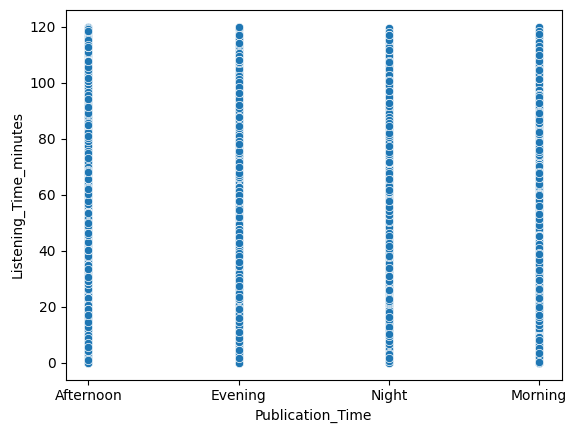

In [ ]:
df = train.sample(10000)

sns.scatterplot(
    x       = df['Publication_Time'],
    y       = df['Listening_Time_minutes']
    )

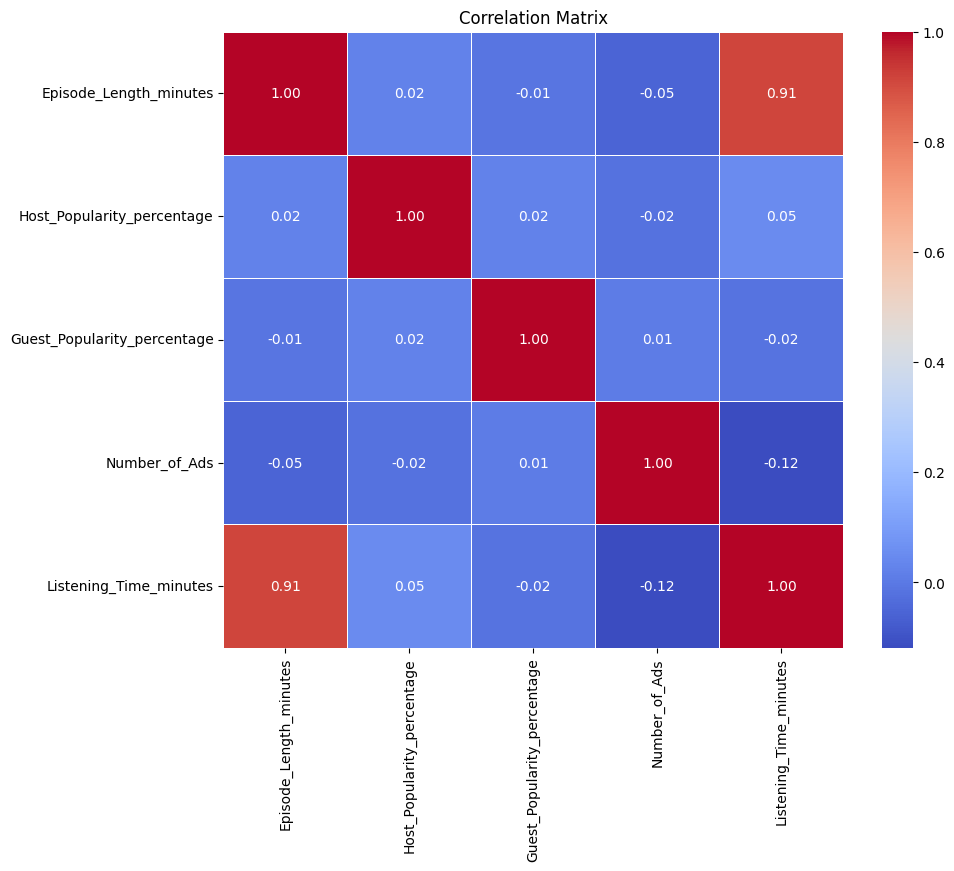

In [ ]:
corr = train[QUANTS].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
na_counts = train.isna().sum()
na_counts

,0
Podcast_Name,0
Episode_Title,0
Episode_Length_minutes,85515
Genre,0
Host_Popularity_percentage,0
Publication_Day,0
Publication_Time,0
Guest_Popularity_percentage,146030
Number_of_Ads,1
Episode_Sentiment,0


In [ ]:
train['Length_Listening_Delta'] = train['Episode_Length_minutes'] - train['Listening_Time_minutes']
train.drop(train[train['Length_Listening_Delta']< 0].index, inplace=True)
len(train)

747222

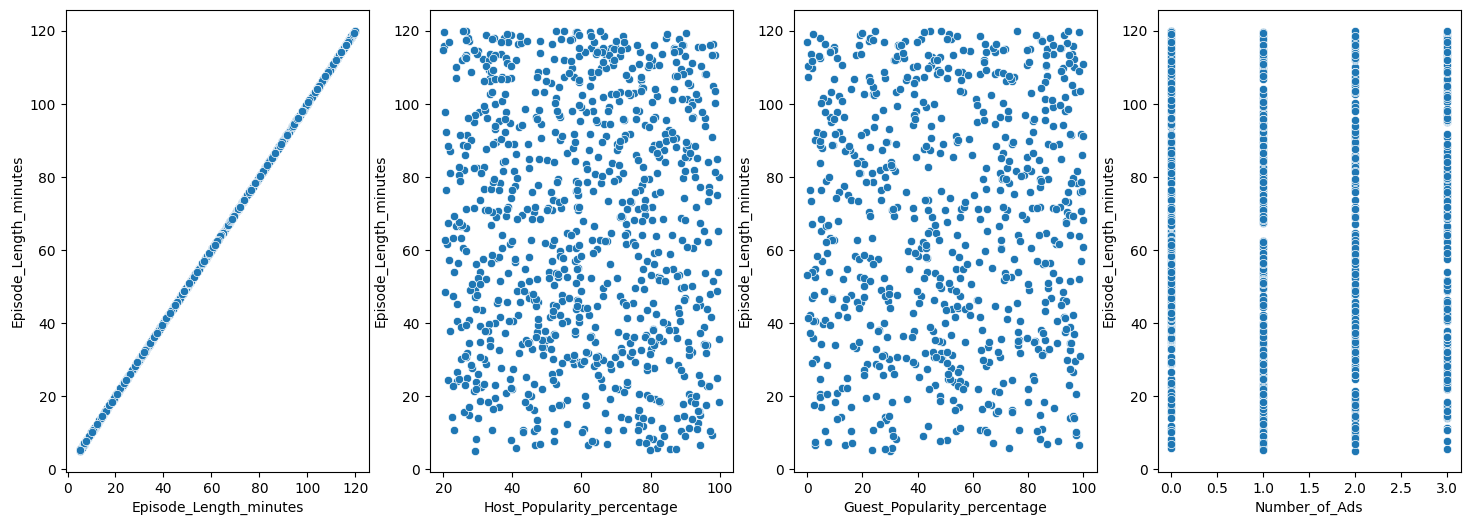

In [ ]:
df = train.sample(1000)

fig, ax =plt.subplots(1,len(QUANTS)-1, figsize=(18,6))


for i, q in enumerate(QUANTS):
    if q == 'Listening_Time_minutes':
        continue
    else:
        sns.scatterplot(
        x       = df[q],
        y       = df['Episode_Length_minutes'],
        ax      = ax[i]
        )

fig.show()

<Axes: xlabel='Episode_Length_minutes', ylabel='Listening_Time_minutes'>

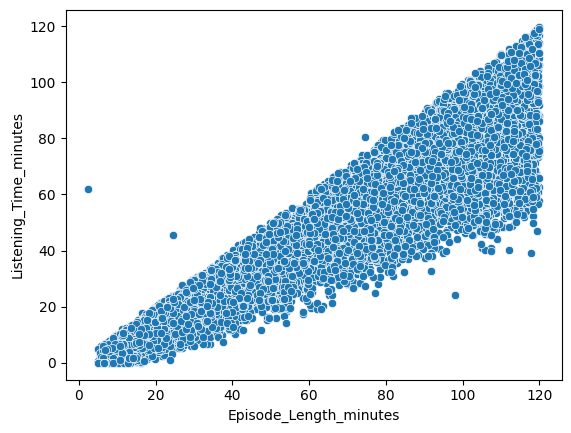

In [ ]:
df = train.sample(10000)

sns.scatterplot(
    x       = df['Episode_Length_minutes'],
    y       = df['Listening_Time_minutes']
    )

<Axes: xlabel='Episode_Length_minutes', ylabel='None'>

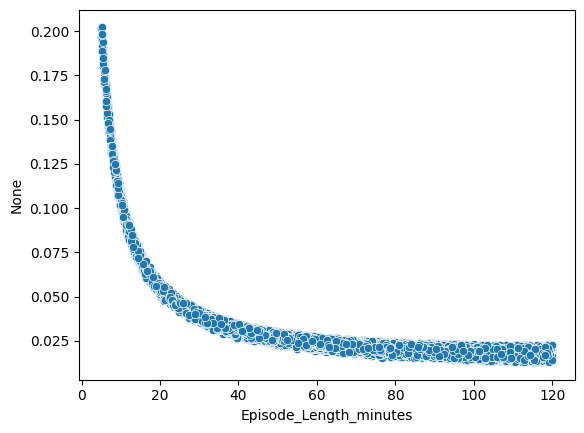

In [67]:
### Predicting Episode Length should be good enough. Just need to figure out how to impute.


#df.drop(df[df['Episode_Length_minutes']>150].index, inplace=True)
Q1, Q2, Q3 = train['Listening_Time_minutes'].quantile([0.25,0.5,0.75])
IQR = Q3 - Q1
trimmed = train[train['Listening_Time_minutes'] <= (1.5 * IQR + Q3)]

Q1, Q2, Q3 = trimmed['Episode_Length_minutes'].quantile([0.25,0.5,0.75])
IQR = Q3 - Q1
trimmed = trimmed[trimmed['Episode_Length_minutes'] <= (1.5 * IQR + Q3)]

df = trimmed.sample(10000)
df['Listening_Z_scores'] = (df['Listening_Time_minutes'] - np.mean( trimmed['Listening_Time_minutes'] ) )/ np.std(trimmed['Listening_Time_minutes'])
df['Length_Z_scores'] = (df['Episode_Length_minutes'] - np.mean( trimmed['Episode_Length_minutes'] ) )/ np.std(trimmed['Episode_Length_minutes'])

sns.scatterplot(
        # x       =  np.sign(df['Length_Z_scores'] - min(df['Length_Z_scores'])) * abs( df['Length_Z_scores'] - min(df['Length_Z_scores']) ) ** (1/3),
        # y       =  np.sign(df['Listening_Z_scores'] - min(df['Listening_Z_scores'])) * abs( df['Listening_Z_scores'] - min(df['Listening_Z_scores'])) ** (1/3)
        x = df['Episode_Length_minutes'],
        y = np.exp(df['Listening_Time_minutes'] / max( trimmed['Listening_Time_minutes']) )/ (df['Episode_Length_minutes'] )

)

In [146]:
def get_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    return outliers

In [30]:
outliers=[]
for q in QUANTS:
    outliers.append(get_outliers(train,q))

outliers = [o for o in outliers if len(o) > 0]

In [56]:
len(outliers)

2

In [31]:
outliers[0]

,Episode_Length_minutes
101637,325.24


In [32]:
outliers[1]

,Number_of_Ads
211159,53.37
283606,103.91
436577,103.00
495919,53.42
537705,103.75
567235,12.00
602553,103.25
672139,103.25
683147,103.88


In [73]:
X_train.groupby(group_by_columns)['exp'].transform('mean')

,exp
0,0.022289
1,0.017399
2,0.019687
3,0.026394
4,0.017007
...,...
9995,0.017729
9996,0.017504
9997,0.040577
9998,0.026344


In [96]:
X_test.groupby(group_by_columns, as_index=False)

In [111]:
X_train.groupby(group_by_columns, as_index=False)['exp'].transform('mean')

,exp
608337,0.020469
240693,0.022332
712462,0.032691
712059,0.020837
407527,0.023655
...,...
616885,0.017237
113407,0.020988
616724,0.021489
45996,0.014993


In [117]:
X_train['exp'] = np.exp(X_train['Listening_Time_minutes'] / max( X_train['Listening_Time_minutes']) )/ (X_train['Episode_Length_minutes'])

X_train_test = pd.concat([X_train, X_test])

group_by_columns = [col for col in CATS if col != 'Episode_Title'] + ['Number_of_Ads']
X_train_test['mean_exp'] = X_train_test.groupby(group_by_columns, as_index=False)['exp'].transform('mean')
X_test['exp'] = X_train_test['mean_exp'].iloc[-1 * len(X_test):]
X_test

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,exp
439375,Study Sessions,Episode 20,78.09,Education,76.22,Thursday,Morning,96.09,2.0,Negative,68.15838,0.018170
676409,Sports Weekly,Episode 56,76.04,Sports,62.08,Sunday,Evening,50.55,2.0,Neutral,60.54022,NaN
710678,Innovators,Episode 23,104.84,Technology,23.63,Wednesday,Night,NaN,0.0,Positive,71.57315,NaN
105366,Lifestyle Lounge,Episode 7,119.63,Lifestyle,48.22,Saturday,Evening,48.22,0.0,Positive,116.81112,NaN
510284,Sound Waves,Episode 35,82.78,Music,37.10,Saturday,Morning,NaN,1.0,Negative,79.92343,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
315369,Game Day,Episode 59,53.77,Sports,51.91,Sunday,Morning,63.78,0.0,Positive,26.44000,0.019782
132424,Life Lessons,Episode 24,NaN,Lifestyle,51.09,Monday,Morning,78.06,0.0,Positive,43.33846,0.019733
376580,Detective Diaries,Episode 62,115.78,True Crime,57.61,Tuesday,Morning,84.90,1.0,Negative,53.95645,NaN
229375,Game Day,Episode 70,34.46,Sports,45.36,Thursday,Evening,NaN,3.0,Negative,26.75000,NaN


In [110]:
X_train = train.sample(10000).copy()
X_test  = train.sample(5000).copy()

X_train['exp'] = np.exp(X_train['Listening_Time_minutes'] / max( X_train['Listening_Time_minutes']) )/ (X_train['Episode_Length_minutes'])
group_by_columns = [col for col in CATS if col != 'Episode_Title'] + ['Number_of_Ads']

X_test = pd.merge(X_test, X_train.groupby(group_by_columns, as_index=False)['exp'].transform('mean'), on=group_by_columns)
#X_test.join( X_train.groupby(group_by_columns, as_index=False)['exp'].agg('mean'), on=group_by_columns, left)

X_test

KeyError: 'Podcast_Name'

# Preprocessing

In [150]:
def preprocess(df):
    df['Episode_Length_minutes']         = np.clip(df['Episode_Length_minutes'], 0.1, 300)
    df['Number_of_Ads']                  = np.clip(df['Number_of_Ads'], 0, 3)
    df["Host_Popularity_percentage"]     = np.clip(df["Host_Popularity_percentage"], 0, 100)
    df["Guest_Popularity_percentage"]    = np.clip(df["Guest_Popularity_percentage"], 0, 100)
    try:
        df['Listening_Time_minutes']     = df[['Listening_Time_minutes', 'Episode_Length_minutes']].min(axis=1)
    except KeyError:
        pass
    return df

# XGBoost

In [149]:
###########################
###### XGBOOST ############
###### OPTIONS ############
###########################
submission      = False
############################

train, test, sample = get_data()
train, test         = preprocess(train), preprocess(test)

# Convenience variables
COLUMNS     = list( train.columns )
FEATURES    = [col for col in COLUMNS if col != 'Listening_Time_minutes']
LABELS      = ['Listening_Time_minutes']
CATS        = list( train.select_dtypes(exclude=np.number).columns )
QUANTS      = list( train.select_dtypes(include=np.number).columns )
GROUP_BY    = [col for col in CATS if col != 'Episode_Title'] + ['Number_of_Ads']


# Get data
X                   = train.copy(deep=True)
y                   = train['Listening_Time_minutes'].copy(deep=True)
num_splits          = 5


model_kwargs = {
'max_depth':                4,
# 'subsample':              0.9,
# 'colsample_bytree':       0.9,
'n_estimators':             6000,
'learning_rate':            0.01,
'eval_metric':              'rmse',
'device':                   'cuda',
'tree_method':              'hist',
'enable_categorical':        True,
'objective':                'reg:squarederror'
}

if not submission:
    model_kwargs.update( {'early_stopping_rounds': 50} )

model = xgb.XGBRegressor( **model_kwargs )

final_score_train = []
final_score_test = []

kf = KFold(n_splits=num_splits, shuffle=True)
for fold_num, (train_index, val_index) in enumerate(kf.split(X)):
    fit_kwargs = {}

    # When not generating submission, use 5-fold validation.
    if not submission:
        X_train     = X.iloc[train_index].copy()
        X_test      = X.iloc[val_index].copy()
        y_train     = y.iloc[train_index]
        y_test      = y.iloc[val_index]

    # On submission generation, train on entire training set.
    if submission:
        X_train     = X
        y_train     = y
        X_test      = test

    ###########################
    ### FEATURE ENGINEERING ###
    ###########################

    X_train.drop(columns='Guest_Popularity_percentage', inplace=True, axis=1)
    X_test.drop(columns='Guest_Popularity_percentage', inplace=True, axis=1)


    ### Category encoding ###
    X_train[CATS]   = X_train[CATS].astype('category').apply(lambda x: x.cat.codes)
    X_test[CATS]    = X_test[CATS].astype('category').apply(lambda x: x.cat.codes)

    ### Group By Aggregations ###
    STATS = ['sum', 'mean', 'median', 'std']
    for stat in STATS:
        X_train_test                   = pd.concat([X_train, X_test])
        X_train_test[stat]             = X_train_test.groupby(GROUP_BY, as_index=False)['Listening_Time_minutes'].transform(stat)
        X_train[stat]                  = X_train_test[stat].iloc[:len(X_train)]
        X_test[stat]                   = X_train_test[stat].iloc[-1 * len(X_test):]

    ### Exp Transform ###
    # X_train_test                = pd.concat([X_train, X_test])
    # X_train_test['exp']         = np.exp(X_train_test['Listening_Time_minutes'] / max( X_train_test['Listening_Time_minutes']) )/ (X_train_test['Episode_Length_minutes'])
    # X_train['exp']              = X_train_test[stat].iloc[:len(X_train)]
    # X_test['exp']               = X_train_test[stat].iloc[-1 * len(X_test):]

    X_train.drop(columns = 'Episode_Title', inplace=True, axis=1)
    X_test.drop(columns = 'Episode_Title', inplace=True, axis=1)

    try:
        X_train.drop(columns='Listening_Time_minutes', inplace=True)
    except KeyError:
        pass

    try:
        X_test.drop(columns='Listening_Time_minutes', inplace=True)
    except KeyError:
        pass

    if not submission:
        fit_kwargs.update({'eval_set' : [(X_train, y_train), (X_test, y_test)]})

    model.fit( X_train, y_train, **fit_kwargs )

    if not submission:
        # Get training and validation scores
        results = model.evals_result()
        final_score_train.append( results['validation_0']['rmse'][-1] )
        final_score_test.append( results['validation_1']['rmse'][-1] )

    if submission:
        #Generate submission and exit
        sample['Listening_Time_minutes'] = model.predict(X_test)
        sample.to_csv(DIR + 'submissions/submission.csv', index=False)
        break

if not submission:
    # Update spreadsheet with run scores so far
    mean_train_score                    = sum(final_score_train) / len(final_score_train)
    mean_val_score                      = sum(final_score_test) / len(final_score_test)

    current_scores                      = pd.DataFrame()
    current_scores['mean_train_score']  = [mean_train_score]
    current_scores['mean_val_score']    = [mean_val_score]

    scores                              = pd.read_csv(DIR + 'average_scores.csv')
    scores                              = pd.concat([scores, current_scores])

    scores.to_csv(DIR + 'average_scores.csv', index=False)

model.get_booster().get_score(importance_type='gain')

[0]	validation_0-rmse:26.94521	validation_1-rmse:26.88055


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:47:27] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:47:27] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[1]	validation_0-rmse:26.74327	validation_1-rmse:26.67908
[2]	validation_0-rmse:26.54397	validation_1-rmse:26.48017
[3]	validation_0-rmse:26.34704	validation_1-rmse:26.28367
[4]	validation_0-rmse:26.15269	validation_1-rmse:26.08969
[5]	validation_0-rmse:25.96067	validation_1-rmse:25.89815
[6]	validation_0-rmse:25.77114	validation_1-rmse:25.70899
[7]	validation_0-rmse:25.58393	validation_1-rmse:25.52220
[8]	validation_0-rmse:25.39916	validation_1-rmse:25.33781
[9]	validation_0-rmse:25.21671	validation_1-rmse:25.15587
[10]	validation_0-rmse:25.03661	validation_1-rmse:24.97612
[11]	validation_0-rmse:24.85866	validation_1-rmse:24.79861
[12]	validation_0-rmse:24.68302	validation_1-rmse:24.62339
[13]	validation_0-rmse:24.50971	validation_1-rmse:24.45045
[14]	validation_0-rmse:24.33861	validation_1-rmse:24.27975
[15]	validation_0-rmse:24.16958	validation_1-rmse:24.11113
[16]	validation_0-rmse:24.00286	validation_1-rmse:23.94498
[17]	validation_0-rmse:23.83831	validation_1-rmse:23.78097
[18]	v

KeyboardInterrupt: 

# CatBoost

In [ ]:
###########################
###### XGBOOST ############
###### OPTIONS ############
###########################
submission      = False
############################

train, test, sample = get_data()
train, test         = preprocess(train), preprocess(test)

# Convenience variables
COLUMNS     = list( train.columns )
FEATURES    = [col for col in COLUMNS if col != 'Listening_Time_minutes']
LABELS      = ['Listening_Time_minutes']
CATS        = list( train.select_dtypes(exclude=np.number).columns )
QUANTS      = list( train.select_dtypes(include=np.number).columns )
GROUP_BY    = [col for col in CATS if col != 'Episode_Title'] + ['Number_of_Ads']


# Get data
X                   = train.copy(deep=True)
y                   = train['Listening_Time_minutes'].copy(deep=True)
num_splits          = 5


model_kwargs = {
'max_depth':                4,
# 'subsample':              0.9,
# 'colsample_bytree':       0.9,
'n_estimators':             6000,
'learning_rate':            0.01,
'eval_metric':              'rmse',
'device':                   'cuda',
'tree_method':              'hist',
'enable_categorical':        True,
'objective':                'reg:squarederror'
}

if not submission:
    model_kwargs.update( {'early_stopping_rounds': 50} )

model = xgb.XGBRegressor( **model_kwargs )

final_score_train = []
final_score_test = []

kf = KFold(n_splits=num_splits, shuffle=True)
for fold_num, (train_index, val_index) in enumerate(kf.split(X)):
    fit_kwargs = {}

    # When not generating submission, use 5-fold validation.
    if not submission:
        X_train     = X.iloc[train_index].copy()
        X_test      = X.iloc[val_index].copy()
        y_train     = y.iloc[train_index]
        y_test      = y.iloc[val_index]

    # On submission generation, train on entire training set.
    if submission:
        X_train     = X
        y_train     = y
        X_test      = test

    ###########################
    ### FEATURE ENGINEERING ###
    ###########################

    X_train.drop(columns='Guest_Popularity_percentage', inplace=True, axis=1)
    X_test.drop(columns='Guest_Popularity_percentage', inplace=True, axis=1)


    ### Category encoding ###
    X_train[CATS]   = X_train[CATS].astype('category').apply(lambda x: x.cat.codes)
    X_test[CATS]    = X_test[CATS].astype('category').apply(lambda x: x.cat.codes)

    ### Group By Aggregations ###
    STATS = ['sum', 'mean', 'median', 'std']
    for stat in STATS:
        X_train_test                   = pd.concat([X_train, X_test])
        X_train_test[stat]             = X_train_test.groupby(GROUP_BY, as_index=False)['Listening_Time_minutes'].transform(stat)
        X_train[stat]                  = X_train_test[stat].iloc[:len(X_train)]
        X_test[stat]                   = X_train_test[stat].iloc[-1 * len(X_test):]

    ### Exp Transform ###
    # X_train_test                = pd.concat([X_train, X_test])
    # X_train_test['exp']         = np.exp(X_train_test['Listening_Time_minutes'] / max( X_train_test['Listening_Time_minutes']) )/ (X_train_test['Episode_Length_minutes'])
    # X_train['exp']              = X_train_test[stat].iloc[:len(X_train)]
    # X_test['exp']               = X_train_test[stat].iloc[-1 * len(X_test):]

    X_train.drop(columns = 'Episode_Title', inplace=True, axis=1)
    X_test.drop(columns = 'Episode_Title', inplace=True, axis=1)

    try:
        X_train.drop(columns='Listening_Time_minutes', inplace=True)
    except KeyError:
        pass

    try:
        X_test.drop(columns='Listening_Time_minutes', inplace=True)
    except KeyError:
        pass

    if not submission:
        fit_kwargs.update({'eval_set' : [(X_train, y_train), (X_test, y_test)]})

    model.fit( X_train, y_train, **fit_kwargs )

    if not submission:
        # Get training and validation scores
        results = model.evals_result()
        final_score_train.append( results['validation_0']['rmse'][-1] )
        final_score_test.append( results['validation_1']['rmse'][-1] )

    if submission:
        #Generate submission and exit
        sample['Listening_Time_minutes'] = model.predict(X_test)
        sample.to_csv(DIR + 'submissions/submission.csv', index=False)
        break

if not submission:
    # Update spreadsheet with run scores so far
    mean_train_score                    = sum(final_score_train) / len(final_score_train)
    mean_val_score                      = sum(final_score_test) / len(final_score_test)

    current_scores                      = pd.DataFrame()
    current_scores['mean_train_score']  = [mean_train_score]
    current_scores['mean_val_score']    = [mean_val_score]

    scores                              = pd.read_csv(DIR + 'average_scores.csv')
    scores                              = pd.concat([scores, current_scores])

    scores.to_csv(DIR + 'average_scores.csv', index=False)

model.get_booster().get_score(importance_type='gain')